In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV



from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score
    
)

import warnings
import os
import joblib

In [2]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_parquet('../data/cleaned/cleaned_data.parquet')

In [9]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,35.48,38.56,0.66,0.92,Potato,4,1
1,914.28,42.68,3.09,2.88,Breakfast,1,0
2,97.03,30.56,38.63,0.02,Beverages,4,1
3,27.05,1.85,0.80,0.53,Beverages,4,0
4,691.15,3.46,1.65,53.93,One Dish Meal,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      895 non-null    object 
 5   servings      895 non-null    object 
 6   high_traffic  895 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 49.1+ KB


In [6]:
X = df.drop('high_traffic', axis=1)
print(X.shape)
y = df['high_traffic']
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

(895, 6)
(895,)


In [7]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()
numerical_columns = X_train.select_dtypes(include='number').columns.tolist()


ct = ColumnTransformer([('pt', PowerTransformer(), numerical_columns), ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])

In [8]:
print(categorical_columns)
print(numerical_columns)

['category', 'servings']
['calories', 'carbohydrate', 'sugar', 'protein']


In [9]:
pipe = Pipeline(steps=[("ct", ct)])
pipe_with_sampling = Pipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42))])


In [10]:
models={
    'LogisticRegression':LogisticRegression(random_state=42),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier':RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42),
    'AdaBoostClassifier':AdaBoostClassifier(random_state=42),
    'XGBoostClassifier':XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoostClassifier': CatBoostClassifier(verbose=0, random_state=42)
}

In [11]:
def get_scores(y_true, y_pred, mode='test'):
    return {
        f"{mode}_precision_score": precision_score(y_true, y_pred),
        f"{mode}_recall_score": recall_score(y_true, y_pred),
        f"{mode}_accuracy_score": accuracy_score(y_true, y_pred),
        f"{mode}_f1_score": f1_score(y_true, y_pred),
        f"{mode}_roc_auc_score": roc_auc_score(y_true, y_pred)
    }

In [12]:
def evaluate_models(X_train, y_train, X_test, y_test, models):
    report = []
    
    for model_name, model in models.items():
        if model_name in ['LogisticRegression', 'KNeighborsClassifier']:
            pipe= ImbPipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42)),('model', model)])
            #grid = GridSearchCV(pipe_with_sampling, param, cv=3, n_jobs=-1, scoring='precision')
            pipe.fit(X_train, y_train)
            
        else:
            pipe = Pipeline(steps=[("ct", ct),('model', model)])
            #grid = GridSearchCV(pipe, param, cv=5, n_jobs=-1, scoring='precision')
            pipe.fit(X_train, y_train)
        
        
        
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)
        
        scores = {
            "model_name": model_name,
            **get_scores(y_train, y_train_pred, mode='train'),
            **get_scores(y_test, y_test_pred)
        }
        
        report.append(scores)
        
    results_df = pd.DataFrame(report).set_index("model_name").round(3)
    return results_df

In [13]:
results_df = evaluate_models(X_train, y_train, X_test, y_test, models)

In [14]:
results_df['test_precision_score'].sort_values(ascending=False)

model_name
LogisticRegression            0.863
GradientBoostingClassifier    0.833
AdaBoostClassifier            0.813
RandomForestClassifier        0.800
CatBoostClassifier            0.786
KNeighborsClassifier          0.775
XGBoostClassifier             0.773
DecisionTreeClassifier        0.726
Name: test_precision_score, dtype: float64

In [15]:
top_3_base_models = results_df['test_precision_score'].sort_values(ascending=False).nlargest(3).index.values.tolist()

top_3_base_models

['LogisticRegression', 'GradientBoostingClassifier', 'AdaBoostClassifier']

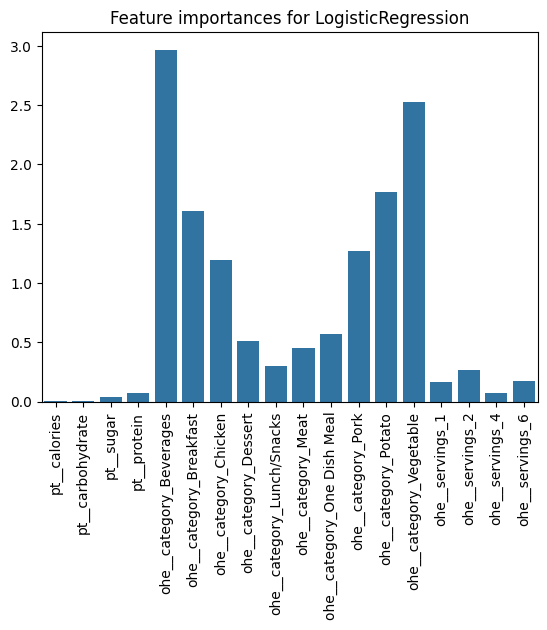

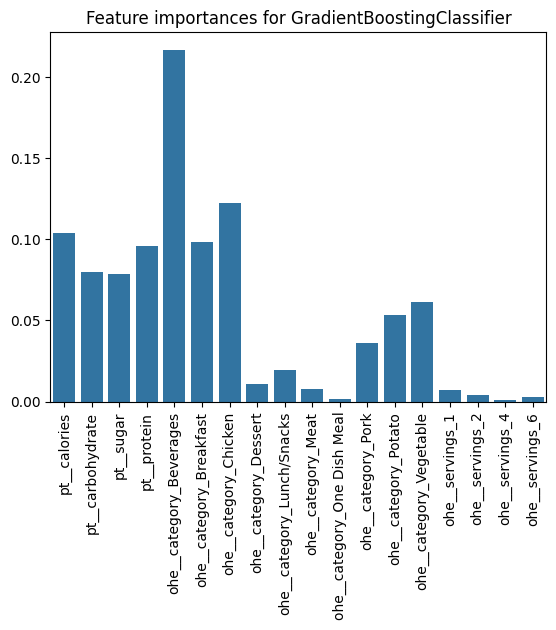

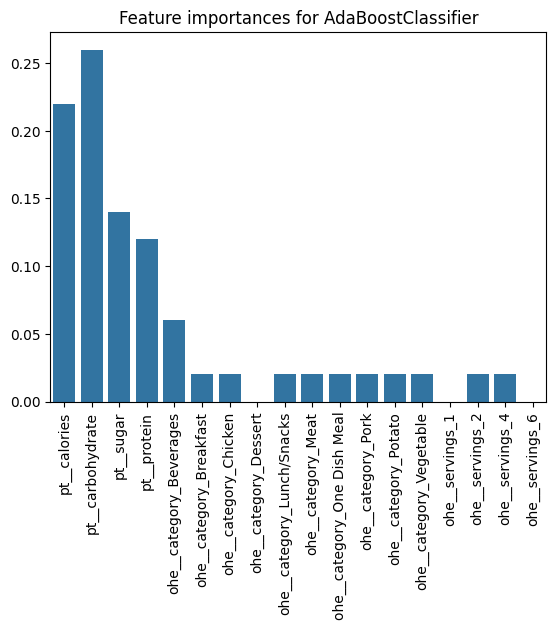

In [16]:
for model_name, model in models.items():
    
    if model_name in top_3_base_models:
    
        if model_name == 'LogisticRegression':

            pipe = ImbPipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42)),('model', model)])
            pipe.fit(X_train, y_train)
            
            importances_series = pd.Series(abs(pipe.named_steps["model"].coef_[0]), index=pipe.named_steps['ct'].get_feature_names_out())
        else:
            pipe = Pipeline(steps=[("ct", ct),('model', model)])
            pipe.fit(X_train, y_train)
    
            importances_series = pd.Series(pipe.named_steps['model'].feature_importances_, index=pipe.named_steps['ct'].get_feature_names_out())
            
        fig, ax = plt.subplots()
        sns.barplot(importances_series)
        plt.title(f"Feature importances for {model_name}")
        plt.xticks(rotation=90)
        plt.show()

In [18]:
params = {
    "LogisticRegression": [
        {
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs', 'liblinear'],
            'model__C': [0.01, 0.1, 1.0, 10.0]
        },
        {
            'model__penalty': ['l1'],
            'model__solver': ['liblinear', 'saga'],
            'model__C': [0.01, 0.1, 1.0, 10.0]
        },
        {
            'model__penalty': ['elasticnet'],
            'model__solver': ['saga'],
            'model__C': [0.01, 0.1, 1.0, 10.0],
            'model__l1_ratio': [0.0, 0.5, 1.0]
        }
    ],

    "GradientBoostingClassifier": {
        'model__loss': ['log_loss'],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__subsample': [0.7, 0.8, 0.9, 1],
        'model__criterion': ['friedman_mse', 'squared_error'],
        'model__max_features': ['sqrt'],
        'model__n_estimators': [10, 50, 100, 150, 200, 250]
    },

    "AdaBoostClassifier": {
        'model__learning_rate': [0.01, 0.1, 1, 10],
        'model__n_estimators': [10, 50, 100, 150, 200, 250],
        'model__algorithm': ['SAMME']
    }
}

In [20]:
top3_models={
    'LogisticRegression':LogisticRegression(random_state=42),
    'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42),
    'AdaBoostClassifier':AdaBoostClassifier(random_state=42)
}

In [21]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test, models, params={}):
    report = []
    best_model_name = None
    best_model = None
    best_params = None
    best_score = 0
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        param = params.get(model_name, {})
        
        
        if model_name in ['LogisticRegression', 'KNeighborsClassifier']:
            
            pipe_with_sampling = ImbPipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42)),('model', model)])
            grid = GridSearchCV(pipe_with_sampling, param, cv=skf, n_jobs=-1, scoring='precision')
            grid.fit(X_train, y_train)
            
        else:
            pipe = Pipeline(steps=[("ct", ct),('model', model)])
            grid = GridSearchCV(pipe, param, cv=skf, n_jobs=-1, scoring='precision')
            grid.fit(X_train, y_train)
        
        
        
        y_train_pred = grid.best_estimator_.predict(X_train)
        y_test_pred = grid.best_estimator_.predict(X_test)
        
        scores = {
            "model_name": model_name,
            **get_scores(y_train, y_train_pred, mode='train'),
            **get_scores(y_test, y_test_pred)
        }
        
        if scores['test_precision_score'] > best_score:
            best_score = scores['test_precision_score']
            best_model_name = model_name
            best_model = grid.best_estimator_
            best_params = grid.best_params_
            
        report.append(scores)
        
    results_df = pd.DataFrame(report).set_index("model_name").round(3)
    print(f"Best model is: {best_model_name} with a precision score of: {best_score:.3f}")
    
    return best_model_name, best_model, best_params, results_df

In [22]:
best_model_name, best_model, best_params, results_df = hyperparameter_tuning(X_train, y_train, X_test, y_test, top3_models, params)

print(f"Best model: {best_model_name}")
print(f"Best params: {best_params}")

Best model is: LogisticRegression with a precision score of: 0.873
Best model: LogisticRegression
Best params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


In [23]:
results_df

,train_precision_score,train_recall_score,train_accuracy_score,train_f1_score,train_roc_auc_score,test_precision_score,test_recall_score,test_accuracy_score,test_f1_score,test_roc_auc_score
model_name,,,,,,,,,,
LogisticRegression,0.847,0.710,0.750,0.773,0.760,0.873,0.579,0.698,0.697,0.727
GradientBoostingClassifier,0.858,0.874,0.838,0.866,0.829,0.823,0.738,0.749,0.778,0.751
AdaBoostClassifier,0.792,0.820,0.764,0.806,0.750,0.854,0.766,0.782,0.808,0.786


In [24]:
dir_path = os.path.join(os.getcwd(),'models')

os.makedirs(dir_path)

joblib.dump(best_model,os.path.join(dir_path,"best_model.joblib"))

['c:\\Users\\Ricsi\\Desktop\\git_folder\\recipe_traffic_classification\\notebooks\\models\\best_model.joblib']